<a href="https://colab.research.google.com/github/AtreyaBandyopadhyay/RAG-with-Langchains/blob/main/Retrival_Augmented_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q -r requirements.txt

In [2]:
import pandas as pd
from datasets import Dataset

In [3]:
from scipy import stats

In [4]:
import os
import openai
import sys
sys.path.append('../..')

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file

openai.api_key  = os.environ['OPENAI_API_KEY']

In [5]:
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter, SentenceTransformersTokenTextSplitter
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.vectorstores import Chroma
from langchain.chains import RetrievalQA
from langchain.chat_models import ChatOpenAI
from langchain.prompts import PromptTemplate

In [43]:
from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    AnswerCorrectness,
    context_recall,
    context_relevancy,
)

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Introduction

### 1.1 What is Retrival Augmented Generation (RAG)?

Sequence to Sequence model like LLM is a knowledge store and can be used for question answering task. But using LLMs for question answering in isolation have limitations:


1.   LLMs cannot be used to answer questions on documents not in the training set. Eg: Private enterprise documents.
2.   LLMs cannot be used to get information from documents made after the LLMs were trained and re-training is often costly.
3. LLMs halucinates and often can make up imaginary answers.

Retrival Augmented Generation (RAG) is a framework to alleviate the above mentioned problems. In RAG for a question we retrive relevant documents from a vector indexed knowledge store and pass these retrived documents along with the context to a LLM. The LLM then can use these retrived documents to answer the question.



### 1.2 RAG Pipeline

The RAG pipeline has the following steps:


1.   Document Loading: Documents are loaded in memory.
2.   List item: Documents are splitted into chunks.
3.   Storage: Chunks are stored in vector store indexed by vector base indexing.
4.   Retrieval: The question is converted into an embedding and based on vector based similarity search relevant chunks are retrived from vector store.
5.   Output/Generation: The retrieved chunks are passed to the LLM along with the question to get the final output.



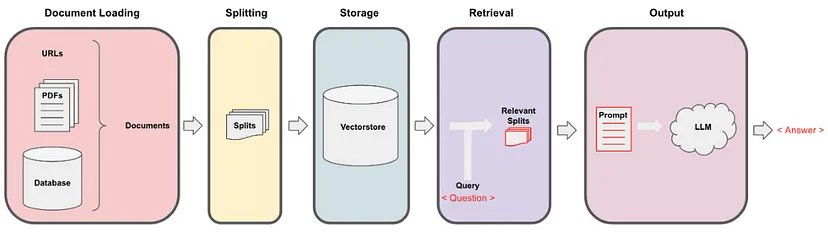   Source: https://www.deeplearning.ai/short-courses/langchain-chat-with-your-data/

## 2. Implementation

### 2.1. Loading

The first 5 chapters of The Little Prince by Antoine de Saint-Exupéry forms our dataset. The chapters is in pdf format so PyPDFLoader has been used.

In [41]:
#Loading the question-answer set.
qa_df=pd.read_excel("/content/drive/MyDrive/RAG/Dataset/Little Prince QA.xlsx")

In [52]:
qa_df

,Questions,Answers,Chapter
0,What is the book 'True Stories from Nature' ab...,It is about primeval forest.,1
1,How does boa contrictors eat their prey?,"Boa constrictors swallow their prey whole, wit...",1
2,How does boa contrictors eat their food?,"Boa constrictors swallow their food whole, wit...",1
3,Why does the author gave up his career as a pa...,The author got disheartened by the faact that ...,1
4,What was the profession of the author?,Pilot airplanes.,1
5,What did the author learn to draw?,The author could only draw boas from inside an...,2
6,Where did the little prince came from?,The little price came from another planet call...,4
7,How big was the little princes planet?,The planet the little price came from was no b...,4
8,What are baobabs?,Baobas are trees as big as castle.,5


In [9]:
questions = list(qa_df[" Questions"].values)
ground_truths= [[x] for x in list(qa_df["Answers"].values)]

In [10]:
# Load PDF
loaders = [
    PyPDFLoader("/content/drive/MyDrive/RAG/Dataset/TheLittlePrince-1.pdf"),
    PyPDFLoader("/content/drive/MyDrive/RAG/Dataset/TheLittlePrince-2.pdf"),
    PyPDFLoader("/content/drive/MyDrive/RAG/Dataset/TheLittlePrince-3.pdf"),
    PyPDFLoader("/content/drive/MyDrive/RAG/Dataset/TheLittlePrince-4.pdf"),
    PyPDFLoader("/content/drive/MyDrive/RAG/Dataset/TheLittlePrince-5.pdf")
]
docs = []
for loader in loaders:
    docs.extend(loader.load())

### 2.2. Spliting

For spliting text document there are various splitters available. In this example **SentenceTransformersTokenTextSplitter** has been used. The chunk size is restricted to 50 tokens. 50, even though a small number is suitable for the task at hand as the answers in our test example appears in a short contagious segment of the document.

In [11]:
token_splitter = SentenceTransformersTokenTextSplitter(chunk_overlap=0, tokens_per_chunk=50)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


.gitattributes:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

data_config.json:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

train_script.py:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

In [12]:
splits = token_splitter.split_documents(docs)

In [13]:
splits[0]

Document(page_content='41 once when i was six years old i saw a magnificent picture in a book, called true stories from nature, about the primeval forest. it was a picture of a boa constrictor in the act of swallowing an animal. here', metadata={'source': '/content/drive/MyDrive/RAG/Dataset/TheLittlePrince-1.pdf', 'page': 0})

### 2.3. Storage

There are various vector stores available. Here ChromaDB has been used.

In [14]:
embedding = OpenAIEmbeddings()

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The class `langchain_community.embeddings.openai.OpenAIEmbeddings` was deprecated in langchain-community 0.1.0 and will be removed in 0.2.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAIEmbeddings`.
  warn_deprecated(


In [15]:
persist_directory = '/content/drive/MyDrive/RAG/Dataset/docs/chroma/'

In [16]:
!rm -rf ./docs/chroma  # remove old database files if any

In [17]:
vectordb = Chroma.from_documents(
    documents=splits,
    embedding=embedding,
    persist_directory=persist_directory
)

In [18]:
print(vectordb._collection.count())

253


### 2.4. Retrieval and Output

For LLM gpt-3.5-turbo has been used and for retrival chain the basic langchain.chains.RetrievalQA suffice.

In [19]:
llm_name = "gpt-3.5-turbo"
llm = ChatOpenAI(model_name=llm_name, temperature=0)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The class `langchain_community.chat_models.openai.ChatOpenAI` was deprecated in langchain-community 0.0.10 and will be removed in 0.2.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import ChatOpenAI`.
  warn_deprecated(


In [20]:
# defining the prompt.
template = """Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer. Use three sentences maximum. Keep the answer as concise as possible.
{context}
Question: {question}
Helpful Answer:"""
QA_CHAIN_PROMPT = PromptTemplate.from_template(template)

In [21]:
qa_chain = RetrievalQA.from_chain_type(
    llm,
    retriever=vectordb.as_retriever(search_type = "similarity", search_kwargs={"k":1}),
    return_source_documents=True,
    chain_type_kwargs={"prompt": QA_CHAIN_PROMPT}
)

In [22]:
answers = []
contexts = []
for query in questions:
  result = qa_chain({"query": query})
  answers.append(result['result'])
  contexts.append([document.page_content for document in result['source_documents']])

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `__call__` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


In [23]:
contexts=[x for x in contexts]

## 3. Evaluation

To evaluate the RAG model the LLM based evaluation framework - RAGAS has been used. The following metrics were choosen for evalutation:

1.   **Context Relevancy**: Context Relevancy metric is a measure of how relevant the retrieved context is to the question and is evaluated based on the question and context. The value ranges between 0 and 1.
2.   **Context Recall**: Context Recall measures how much the retrieved context aligns with the ground truth answer. It is evaluated using the ground truth and the retrieved context and ranges between 0 and 1.
3.   **Faithfullness**: Faithfullness measures how much of the claims in the generated answers can be inferred from the retrieved context. It ranges bwtween 0 and 1.
4.   **Answer Correctness**: Answer Correctness is the measure of the accuracy of the generated answer when compared with the ground truth. It ranges between 0 and 1. Answer correctness measures two aspects: semantic similarity and factual similarity.







In [24]:
dataset={
    "question": questions,
    "answer": answers,
    "contexts": contexts,
    "ground_truths": ground_truths
}
dataset = Dataset.from_dict(dataset)

In [49]:
answer_correctness = AnswerCorrectness(
    weights=[0,1] # we give 0 weight to semantic similarity and 1 to factual similarity
)
result = evaluate(
    dataset = dataset,
    metrics=[
        context_relevancy,
        context_recall,
        faithfulness,
        answer_correctness,
    ],
)

evaluating with [context_relevancy]


100%|██████████| 1/1 [00:05<00:00,  5.49s/it]


evaluating with [context_recall]


100%|██████████| 1/1 [00:08<00:00,  8.23s/it]


evaluating with [faithfulness]


100%|██████████| 1/1 [00:37<00:00, 37.26s/it]


evaluating with [answer_correctness]


100%|██████████| 1/1 [00:13<00:00, 13.28s/it]


In [50]:
result=result.to_pandas()

### 3.1 Result Metrics

In [51]:
result

,question,answer,contexts,ground_truths,context_relevancy,context_recall,faithfulness,answer_correctness
0,What is the book 'True Stories from Nature' ab...,The book 'True Stories from Nature' is about v...,[41 once when i was six years old i saw a magn...,[It is about primeval forest.],0.333333,1.0,0.5,0.826213
1,How does boa contrictors eat their prey?,Boa constrictors swallow their prey whole with...,[41 Once when I was six years old I saw a mag...,"[Boa constrictors swallow their prey whole, wi...",0.076923,1.0,1.0,0.990116
2,How does boa contrictors eat their food?,Boa constrictors swallow their prey whole with...,[41 Once when I was six years old I saw a mag...,"[Boa constrictors swallow their food whole, wi...",0.076923,1.0,1.0,0.983559
3,Why does the author gave up his career as a pa...,The author gave up his career as a painter bec...,"[The grown-ups' response, this time, was to ad...",[The author got disheartened by the faact that...,0.250000,1.0,1.0,0.950494
4,What was the profession of the author?,The author's profession was a pilot.,"[5understand anything by themselves, and it is...",[Pilot airplanes.],0.066667,1.0,1.0,0.896916
5,What did the author learn to draw?,The author learned to draw boa constrictors.,"[The grown-ups' response, this time, was to ad...",[The author could only draw boas from inside a...,0.000000,1.0,1.0,0.902036
6,Where did the little prince came from?,The little prince came from another planet.,[93 It took me a long time to learn where he ...,[The little price came from another planet cal...,0.153846,1.0,1.0,0.852263
7,How big was the little princes planet?,The little prince's planet was scarcely any la...,[114 I had thus learned a second fact of grea...,[The planet the little price came from was no ...,0.083333,1.0,1.0,0.934103
8,What are baobabs?,Baobabs are a type of plant or tree.,[this is. that would be very useful to them if...,[Baobas are trees as big as castle.],0.000000,1.0,0.0,0.897325


### 3.2 Individual Results

In [29]:
def display(result,i):

  print(f"Question: {result.loc[i,['question']].iloc[0]} \n")
  print(f"Answers: {result.loc[i,['answer']].iloc[0]} \n")
  print(f"Contexts: {result.loc[i,['contexts']].iloc[0]} \n")
  print(f"Ground Truths: {result.loc[i,['ground_truths']].iloc[0]} \n")
  print(result.loc[i,['context_relevancy',	'context_recall',	'faithfulness',	'answer_relevancy']])

In [30]:
display(result,i=0)

Question: What is the book 'True Stories from Nature' about? 

Answers: The book 'True Stories from Nature' is about various stories and facts related to the natural world. 

Contexts: ['41 once when i was six years old i saw a magnificent picture in a book, called true stories from nature, about the primeval forest. it was a picture of a boa constrictor in the act of swallowing an animal. here'] 

Ground Truths: ['It is about primeval forest.'] 

context_relevancy    0.333333
context_recall            1.0
faithfulness              0.5
answer_relevancy          1.0
Name: 0, dtype: object


In [31]:
display(result,i=1)

Question: How does boa contrictors eat their prey? 

Answers: Boa constrictors swallow their prey whole without chewing it. 

Contexts: ['41  Once when I was six years old I saw a magnificent picture in a book, called True Stories from Nature, about the primeval forest. It was a picture of a boa constrictor in the act of swallowing an animal. Here is a copy of the drawing.  \n In the book it said: "Boa constrictors swallow their prey whole, without chewing it. After that they are not able to move, and they sleep through the six months that they need for digestion."  I pondered deeply, then, over the adventures of the jungle. And after some work with a colored pencil I succeeded in making my first drawing. My Drawing Number One. It looked something like this:  \n I showed my masterpiece to the grown-ups, and asked them whether the drawing frightened them.  But they answered: "Frighten? Why should any one be frightened by a hat?"  My drawing was not a picture of a hat. It was a picture o

In [32]:
display(result,i=2)

Question: How does boa contrictors eat their food? 

Answers: Boa constrictors swallow their prey whole without chewing it. 

Contexts: ['41  Once when I was six years old I saw a magnificent picture in a book, called True Stories from Nature, about the primeval forest. It was a picture of a boa constrictor in the act of swallowing an animal. Here is a copy of the drawing.  \n In the book it said: "Boa constrictors swallow their prey whole, without chewing it. After that they are not able to move, and they sleep through the six months that they need for digestion."  I pondered deeply, then, over the adventures of the jungle. And after some work with a colored pencil I succeeded in making my first drawing. My Drawing Number One. It looked something like this:  \n I showed my masterpiece to the grown-ups, and asked them whether the drawing frightened them.  But they answered: "Frighten? Why should any one be frightened by a hat?"  My drawing was not a picture of a hat. It was a picture o

In [33]:
display(result,i=3)

Question: Why does the author gave up his career as a painter? 

Answers: The author gave up his career as a painter because the grown-ups advised him to focus on subjects like geography, history, arithmetic, and grammar instead of drawing. The author was disheartened by the failure of his first two drawings. 

Contexts: ["The grown-ups' response, this time, was to advise me to lay aside my drawings of boa constrictors, whether from the inside or the outside, and devote myself instead to geography, history, arithmetic, and grammar. That is why, at the age of six, I gave up what might have been a magnificent career as a painter. I had been disheartened by the failure of my Drawing Number One and my Drawing Number Two. Grown-ups never"] 

Ground Truths: ['The author got disheartened by the faact that the grownups did not appreciate two of his drawings and asked him to concentrate more on geography, history, arithmetic, and grammar.'] 

context_relevancy        0.25
context_recall        

In [34]:
display(result,i=4)

Question: What was the profession of the author? 

Answers: The author's profession was a pilot. 

Contexts: ['5understand anything by themselves, and it is tiresome for children to be always and forever explaining things to them.  So then I chose another profession, and learned to pilot airplanes. I have flown a little over all parts of the world; and it is true that geography has been very useful to me. At a glance I can distinguish China from Arizona. If one gets lost in the night, such knowledge is valuable.  In the course of this life I have had a great many encounters with a great many people who have been concerned with matters of consequence. I have lived a great deal among grown-ups. I have seen them intimately, close at hand. And that hasn\'t much improved my opinion of them.  Whenever I met one of them who seemed to me at all clear-sighted, I tried the experiment of showing him my Drawing Number One, which I have always kept. I would try to find out, so, if this was a person

In [35]:
display(result,i=5)

Question: What did the author learn to draw? 

Answers: The author learned to draw boa constrictors. 

Contexts: ["The grown-ups' response, this time, was to advise me to lay aside my drawings of boa constrictors, whether from the inside or the outside, and devote myself instead to geography, history, arithmetic, and grammar. That is why, at the age of six, I gave up what might have been a magnificent career as a painter. I had been disheartened by the failure of my Drawing Number One and my Drawing Number Two. Grown-ups never"] 

Ground Truths: ['The author could only draw boas from inside and boas from outside.'] 

context_relevancy    0.0
context_recall       1.0
faithfulness         1.0
answer_relevancy     1.0
Name: 5, dtype: object


In [36]:
display(result,i=6)

Question: Where did the little prince came from? 

Answers: The little prince came from another planet. 

Contexts: ['93  It took me a long time to learn where he came from. The little prince, who asked me so many questions, never seemed to hear the ones I asked him. It was from words dropped by chance that, little by little, everything was revealed to me.  The first time he saw my airplane, for instance (I shall not draw my airplane; that would be much too complicated for me), he asked me:  "What is that object?"  "That is not an object. It flies. It is an airplane. It is my airplane."  And I was proud to have him learn that I could fly.  He cried out, then:  "What! You dropped down from the sky?"  "Yes," I answered, modestly.  "Oh! That is funny!"  And the little prince broke into a lovely peal of laughter, which irritated me very much. I like my misfortunes to be taken seriously.  Then he added:  "So you, too, come from the sky! Which is your planet?"  At that moment I caught a glea

In [37]:
display(result,i=7)

Question: How big was the little princes planet? 

Answers: The little prince's planet was scarcely any larger than a house. 

Contexts: ['114  I had thus learned a second fact of great importance: this was that the planet the little prince came from was scarcely any larger than a house!  But that did not really surprise me much. I knew very well that in addition to the great planets--such as the Earth, Jupiter, Mars, Venus--to which we have given names, there are also hundreds of others, some of which are so small that one has a hard time seeing them through the telescope. When an astronomer discovers one of these he does not give it a name, but only a number. He might call it, for example, "Asteroid 325."  I have serious reason to believe that the planet from which the little prince came is the asteroid known as B-612.  This asteroid has only once been seen through the telescope. That was by a Turkish astronomer, in 1909.  \n On making his discovery, the astronomer had presented it t

In [38]:
display(result,i=8)

Question: What are baobabs? 

Answers: Baobabs are a type of plant or tree. 

Contexts: ['this is. that would be very useful to them if they were to travel some day. sometimes, " he added, " there is no harm in putting off a piece of work until another day. but when it is a matter of baobabs'] 

Ground Truths: ['Baobas are trees as big as castle.'] 

context_relevancy    0.0
context_recall       1.0
faithfulness         0.0
answer_relevancy     1.0
Name: 8, dtype: object
